<a href="https://colab.research.google.com/github/nm2028/Social-Media-Link-Prediction-Using-Random-Forest-and-XGBoost-Machine-Learning-Algorithms/blob/main/Social_Media_Link_Prediction_Group_27.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GLA UNIVERSITY, MATHURA 
##Social Network Link Prediction 
### Solution submitted by: Group 27
Nikhil Mishra,
Ved Prakash Chaubey,
Anoop Kumar,
Kuldeep Kumar
## Mentor - Dr. Gaurav Kumar


## Problem statement: 
Given a directed social graph, predict missing links to recommend users (missing link prediction in a network).


## Data overview
Data  sourced from Facebook's Recruiting Challenge on kaggle https://www.kaggle.com/c/FacebookRecruiting  

Data contains two columns - source and destination:

    - Data columns (total 2 columns):  
    - source_node         int64  
    - destination_node    int64  


## Business objectives and constraints:  
- Probability of prediction is useful to recommend highest probability links first. 
- No low-latency requirement 

## Formulating a supervised machine learning task:

Given the directed graph, we generate training samples of good and bad links (i.e.existing links and missing links) and for each link we engineer new features such as 'number of followers', 'is user followed back', 'page rank', katz score', 'adar index', some Weight features etc. Thereafter, we train Machine Learning models on these features to predict if the link is present or not. 

    References: 
    1. https://www.cs.cornell.edu/home/kleinber/link-pred.pdf
    2. https://www3.nd.edu/~dial/publications/lichtenwalter2010new.pdf


## Performance metrics for supervised learning:  
- Both Precision and Recall is important so F1 will be a good choice.
- Confusion matrix. 
- Accuracy can also be reported. 

# 0. Installing/Importing libraries 

In [2]:
# importing necessary libraries
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
#-----------------------------------------------------------------#
import csv
import pandas as pd # pandas to create small dataframes 
import datetime # Convert to unix time
import time # Convert to unix time
import random
# if numpy is not installed already : pip3 install numpy
import numpy as np # do arithmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib.pyplot as plt
import seaborn as sns # Visualizations
from matplotlib import rcParams # Size of plots  
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb # ML ensemble model
#-----------------------------------------------------------------#
from pandas import HDFStore, DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm
#-----------------------------------------------------------------#
import networkx as nx
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# 1. Loading and exploring data

In [1]:
# mount google drive

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# reading data from drive 

my_path = '/content/gdrive/My Drive/social media link prediction/data/'
train_data = pd.read_csv(my_path + 'train.csv')

In [5]:
# display first and last few rows 

train_data.head(10)

,source_node,destination_node
0,1,690569
1,1,315892
2,1,189226
3,2,834328
4,2,1615927
5,2,1194519
6,2,470294
7,2,961886
8,2,626040
9,3,176995


In [6]:
train_data.tail(10)

,source_node,destination_node
9437509,1862219,1150552
9437510,1862219,1396892
9437511,1862219,1076013
9437512,1862219,1629286
9437513,1862219,1829265
9437514,1862219,1187308
9437515,1862219,563943
9437516,1862219,1044046
9437517,1862219,1022613
9437518,1862220,1748794


In [7]:
# shape of the complete data and all columns 
print(train_data.shape)
print(train_data.columns)

(9437519, 2)
Index(['source_node', 'destination_node'], dtype='object')


Total Rows = 9437519 ~ 9.5 million

Total Columns = 2

Columns = {'source_node',  'destination_node}


In [ ]:
# high level info
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9437519 entries, 0 to 9437518
Data columns (total 2 columns):
 #   Column            Dtype
---  ------            -----
 0   source_node       int64
 1   destination_node  int64
dtypes: int64(2)
memory usage: 144.0 MB
None


In [ ]:
# check for null entries if any
print(train_data[train_data.isna().any(1)])

Empty DataFrame
Columns: [source_node, destination_node]
Index: []


In [ ]:
# check for duplicate entries 
print("Number of duplicate entries: ", sum(train_data.duplicated()))

Number of duplicate entries:  0


In [ ]:
# remove header and save graph into a different csv file 

train_data.to_csv(my_path + 'train_noheader.csv', header = False, index = False)
print("saved the graph into file")


saved the graph into file


In [ ]:
# graph node & edges info using Python networkx API
# NetworkX is a Python package for the creation, manipulation
# ,and study of the structure, dynamics, and functions of complex networks.

g = nx.read_edgelist(my_path + 'train_noheader.csv', delimiter = ',', create_using = nx.DiGraph())
print(nx.info(g))

Name: 
Type: DiGraph
Number of nodes: 1862220
Number of edges: 9437519
Average in degree:   5.0679
Average out degree:   5.0679


Nodes (Total number of distinct Users) ~ 1.86M

Edges (Total Links) ~ 9.43M

Name: 
Type: DiGraph
Number of nodes: 66
Number of edges: 50
Average in degree:   0.7576
Average out degree:   0.7576


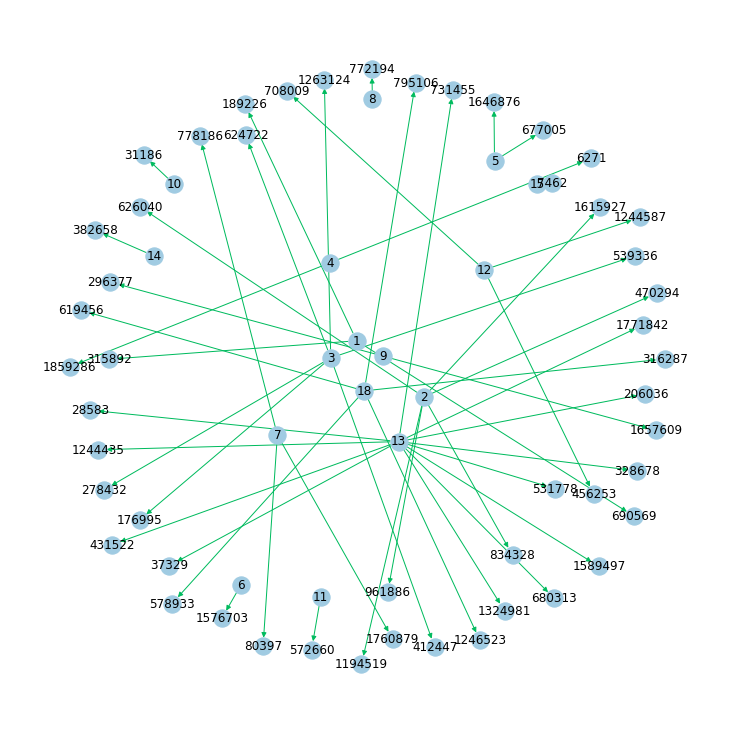

In [ ]:
# visualizing a subgraph 
# first store top 50 records in a new file
train_data[:50].to_csv(my_path + 'train_noheader_sample.csv', header = False, index = False)

subgraph = nx.read_edgelist(my_path + 'train_noheader_sample.csv', delimiter =',', 
                            create_using = nx.DiGraph(), nodetype = int)

# Reference: https://stackoverflow.com/questions/9402255/drawing-a-huge-graph-with-networkx-and-matplotlib
plt.figure(figsize = (10, 10))
pos = nx.spring_layout(subgraph)
nx.draw(subgraph, pos, node_color = '#A0CBE2', edge_color = '#00bb5e', 
        width = 1, edge_cmap = plt.cm.Blues, with_labels = True)

# save the above figure as .pdf
'''plt.savefig(my_path + 'sample_graph.pdf')'''

# display subgraph
print(nx.info(subgraph))

# 2. Exploratory Data Analysis 

In [ ]:
# No. of Unique users

print("The number of unique users = ", len(g.nodes()))

The number of unique users =  1862220


~ 1.8 million Unique users in the dataset

## 2.1 Follower analysis 

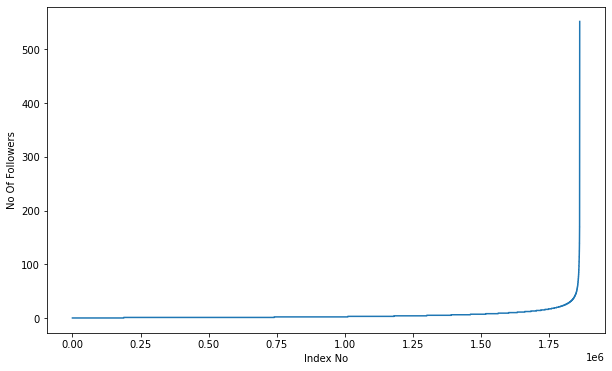

In [ ]:
indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10, 6))
plt.plot(indegree_dist)
plt.xlabel('Index No')
plt.ylabel('No Of Followers')
plt.show()

In the above plot, every point on x-axis represents a distinct user and y-axis represents their followers. 

> #### Key Takeaways: 

* A very high majority of users have very few followers 

* A small subset of users have over 50 followers 


Now let's zoom above plot a bit (i.e.consider first 1.5 M users only)

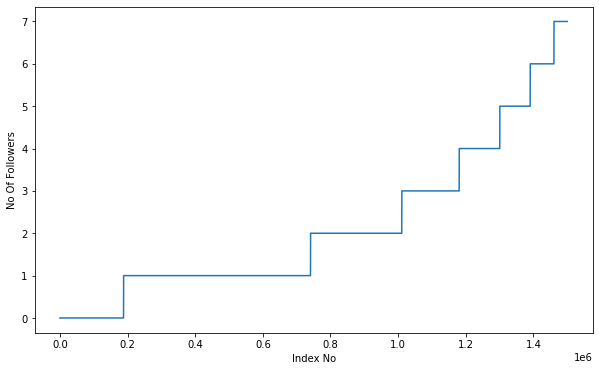

In [ ]:
indegree_dist = list(dict(g.in_degree()).values()) # dict(g.in_degree()) format is 'User': No. of follwers
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(indegree_dist[0:1500000])
plt.xlabel('Index No')
plt.ylabel('No Of Followers')
plt.show()

> #### Key Takeaways:

* 1.5M Users of the total 1.86M users have less than 10 followers 

* More than half of the users have zero or just 1 follower 

* Almost 90% users have less than 5 followers

In [ ]:
# 0 - 100 percentile 

for i in range(0,110, 10):
    print(i, 'percentile value is', np.percentile(indegree_dist, i))

0 percentile value is 0.0
10 percentile value is 0.0
20 percentile value is 1.0
30 percentile value is 1.0
40 percentile value is 2.0
50 percentile value is 2.0
60 percentile value is 3.0
70 percentile value is 5.0
80 percentile value is 7.0
90 percentile value is 12.0
100 percentile value is 552.0


> #### Key Takeaways:

* At least 10% of the Users do not have any follower.

* 50% Users have 2 or less followers

* 90% of the Users have 12 or less followers

In [ ]:
# 90-100 percentile

for i in range(0,11):
    print(90+i,'percentile value is', np.percentile(indegree_dist, 90+i))

90 percentile value is 12.0
91 percentile value is 13.0
92 percentile value is 14.0
93 percentile value is 15.0
94 percentile value is 17.0
95 percentile value is 19.0
96 percentile value is 21.0
97 percentile value is 24.0
98 percentile value is 29.0
99 percentile value is 40.0
100 percentile value is 552.0


> #### Key Takeaways:

* 90% Users have 12 or less followers 

* 98% of the Users have less than 40 followers 

* A very small subset of Users have unconventionally large number of followers. These maybe celebrities.

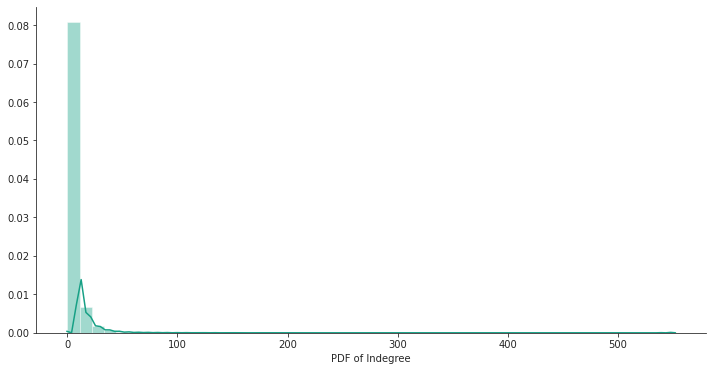

In [ ]:
# plotting PDF of indegree (followers)

sns.set_style('ticks')
plt.figure(figsize = (12, 6))
sns.distplot(indegree_dist, color = '#16A085')
plt.xlabel('PDF of Indegree')
sns.despine()

As seen from the above PDF plot, most of the followers have less than 50 followers which corroborates our above findings. 

In [ ]:
print('No. of Users having zero followers are', sum(np.array(indegree_dist) == 0),
      'and % is', sum(np.array(indegree_dist) == 0)*100/len(indegree_dist))

No. of Users having zero followers are 188043 and % is 10.097786512871734


* About 10.1 % Users are not being followed by any other User. 

(It means they might be following one or more other users, but they themselves aren't followed by any user)

## 2.2 Followee analysis 

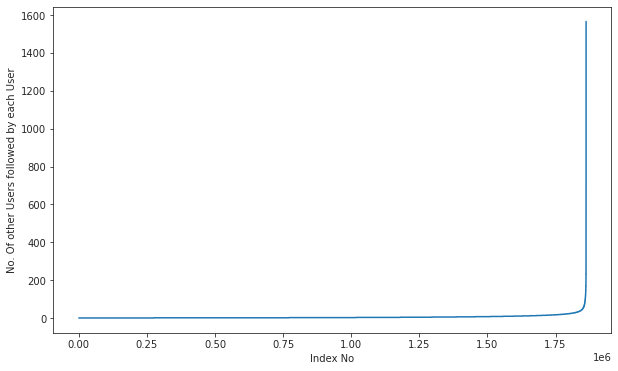

In [ ]:
# dict(g.out_degree()) format is, 'User': No. of other Users followed 
outdegree_dist = list(dict(g.out_degree()).values()) 
outdegree_dist.sort()
plt.figure(figsize = (10, 6))
plt.plot(outdegree_dist)
plt.xlabel('Index No')
plt.ylabel('No. Of other Users followed by each User')
plt.show()

In the above plot, every point on x-axis represents a distinct user and y-axis represents the number of people being followed by the users . 

> #### Key Takeaways: 

* A very high majority of users follow very few other Users   

* A small subset of Users follow 10 other Users

* At least 1 user follows about 1600 other Users


Now let's zoom above plot a bit (i.e.consider first 1.5 M users only)



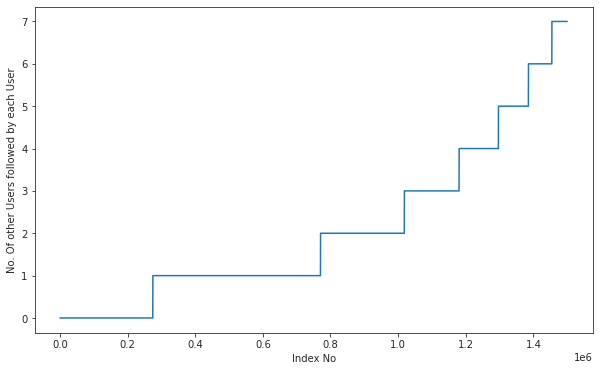

In [ ]:
outdegree_dist = list(dict(g.out_degree()).values())
outdegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(outdegree_dist[0:1500000])
plt.xlabel('Index No')
plt.ylabel('No. Of other Users followed by each User')
plt.show()

> #### Key Takeaways:

* 1.5M Users of the total 1.86M users follow 7 or less other Users.

* More than half of the users follow either no other User or just 1 other User.

* Almost 90% Users follow less than 6 other Users

In [ ]:
# 0 - 100 percentile 

for i in range(0,110, 10):
    print(i, 'percentile value is', np.percentile(outdegree_dist, i))

0 percentile value is 0.0
10 percentile value is 0.0
20 percentile value is 1.0
30 percentile value is 1.0
40 percentile value is 1.0
50 percentile value is 2.0
60 percentile value is 3.0
70 percentile value is 5.0
80 percentile value is 7.0
90 percentile value is 12.0
100 percentile value is 1566.0


> #### Key Takeaways:

* At least 10% of the Users do not follow any other User.

* 50% Users follow 2 or less Users

* 90% of the Users follow 12 or less Users

In [ ]:
# 90-100 percentile

for i in range(0,11):
    print(90+i,'percentile value is', np.percentile(outdegree_dist, 90+i))

90 percentile value is 12.0
91 percentile value is 13.0
92 percentile value is 14.0
93 percentile value is 15.0
94 percentile value is 17.0
95 percentile value is 19.0
96 percentile value is 21.0
97 percentile value is 24.0
98 percentile value is 29.0
99 percentile value is 40.0
100 percentile value is 1566.0


> #### Key Takeaways:

* 90% Users follow 12 or less Users

* 99% of the Users follow 40 or less other Users 

* A very small subset of Users follow exceptionally large number of Users 

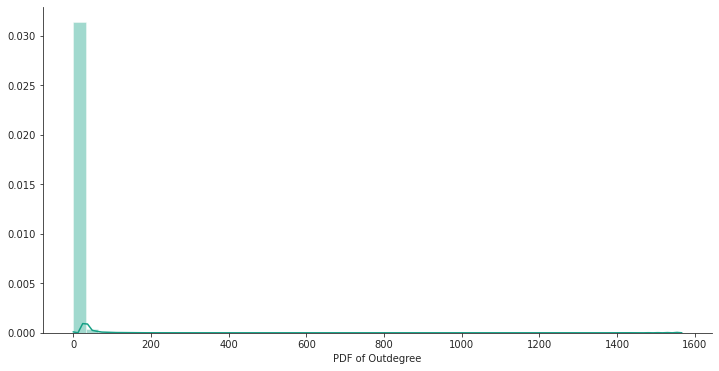

In [ ]:
# plotting PDF of outdegree (user following other users )

plt.figure(figsize = (12, 6))
sns.distplot(outdegree_dist, color = '#16A085')
plt.xlabel('PDF of Outdegree')
sns.despine()

As seen from the above PDF plot, majority of the Users follow less than 50 other Users and at least 1 user follow 1500+ other Users. This is in conjunction with our above findings. 

In [ ]:
print('No. of Users those are not following any other User are', sum(np.array(outdegree_dist)==0),
      'and % is', sum(np.array(outdegree_dist)==0)*100/len(outdegree_dist) )

No of Users those are not following any other User are 274512 and % is 14.741115442858524


* About 14.74 % Users do not follow any other User.

(It means they might be followed one or more other users, but they themselves aren't following any other user)

## 2.3 Followers & Followees combined Analysis

In [ ]:
from collections import Counter

dict_in = dict(g.in_degree())
dict_out = dict(g.out_degree())
d = Counter(dict_in) + Counter(dict_out)
in_out_degree = np.array(list(d.values()))

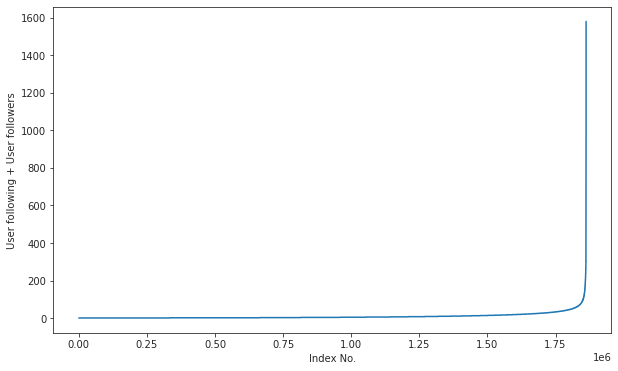

In [ ]:
in_out_degree_sort = sorted(in_out_degree)
plt.figure(figsize = (10,6))
plt.plot(in_out_degree_sort)
plt.xlabel('Index No.')
plt.ylabel('User following + User followers')
plt.show()

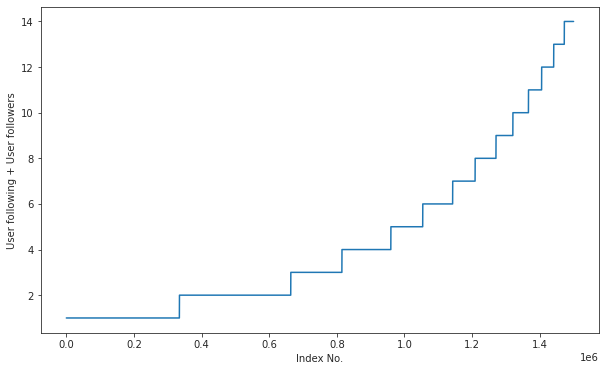

In [ ]:
in_out_degree_sort = sorted(in_out_degree)
plt.figure(figsize = (10,6))
plt.plot(in_out_degree_sort[0:1500000])
plt.xlabel('Index No.')
plt.ylabel('User following + User followers')
plt.show()

In [ ]:
# 0 - 100 percentile 

for i in range(0,110, 10):
    print(i, 'percentile value is', np.percentile(in_out_degree_sort, i))

0 percentile value is 1.0
10 percentile value is 1.0
20 percentile value is 2.0
30 percentile value is 2.0
40 percentile value is 3.0
50 percentile value is 4.0
60 percentile value is 6.0
70 percentile value is 9.0
80 percentile value is 14.0
90 percentile value is 24.0
100 percentile value is 1579.0


In [ ]:
# 90-100 percentile
for i in range(0,11):
    print(90+i,'percentile value is', np.percentile(in_out_degree_sort, 90+i))

90 percentile value is 24.0
91 percentile value is 26.0
92 percentile value is 28.0
93 percentile value is 31.0
94 percentile value is 33.0
95 percentile value is 37.0
96 percentile value is 41.0
97 percentile value is 48.0
98 percentile value is 58.0
99 percentile value is 79.0
100 percentile value is 1579.0


In [ ]:
# A predecessors of n is a node m such that there exists a directed edge from m to n.
# A successor of m is a node n such that there exists a directed edge from m to n.

count = 0
for i in g.nodes():
    if len(list(g.predecessors(i))) == 0 and len(list(g.successors(i))) == 0:
            count += 1
print('Number of Users that do not follow anyone and are also not being followed by any other Users = ', count)

Number of Users that do not follow anyone and are also not being followed by any other Users =  0


This is kinda obvious, the Users appear in our dataset as there exists a direct link between them.

In [ ]:
print('Min of no of User followers + following is', np.min(in_out_degree))
print('No. of Users having minimum no of followers + following is', np.sum(in_out_degree == in_out_degree.min()))

Min of no of User followers + following is 1
No. of Users having minimum no of followers + following is 334291


It means that there are 334k such Users that either follow just one User or are being followed by just one other User.  

In [ ]:
print('Max of no of followers + following is', np.max(in_out_degree))
print('No. of Users having maximum no of followers + following is ', np.sum(in_out_degree == in_out_degree.max()))

Max of no of followers + following is 1579
No. of Users having maximum no of followers + following is  1


In [ ]:
print('No. of Users having followers + following less than 10 are', np.sum(in_out_degree < 10))

No. of Users having followers + following less than 10 are 1320326


According to [WolframAlpha ](https://mathworld.wolfram.com/WeaklyConnectedComponent.html), A weakly connected component is a maximal subgraph of a directed graph such that for every pair of vertices u, v in the subgraph, there is an undirected path from u to v and a directed path from v to u. 

In [ ]:
# weakly connected components 

print('No. of weakly connected components is', len(list(nx.weakly_connected_components(g))))
count = 0
for i in list(nx.weakly_connected_components(g)):
    if len(i) == 2:
        count += 1

print('weakly connected components with 2 nodes is',count)

No. of weakly connected components is 45558
weakly connected components with 2 nodes is 32195


# 3. Formulating a Machine Learning Problem 

## 3.1 Generating some edges which are not present in graph for Supervised learning  

Generated 'bad links' from graph which are not in graph and whose shortest path is greater than 2. 

In [ ]:
%%time
# Introducing missing edges from given graph
# getting all possible set of edges

# create a dictionary such that {(src, dest): 1} if there is an edge between them
r = csv.reader(open(my_path + 'train_noheader.csv', 'r'))
edges = dict()
for edge in r:
    edges[(edge[0], edge[1])] = 1

missing_edges = set([])
while (len(missing_edges) < 9437519):
    ui = random.randint(1, 1862220)
    uj = random.randint(1, 1862220)
    temp = edges.get((ui, uj), -1)

    if temp == -1 and ui != uj:
        try:
            if nx.shortest_path_length(g, source = ui, target = uj) >= 2:
                missing_edges.add((ui, uj))
            else:
                continue
        except:
            missing_edges.add((ui, uj))
    else:
        continue

# take a pickle dump of missing edges file
pickle.dump(missing_edges, open(my_path + 'missing_edges_final.p','wb'))

CPU times: user 1min 1s, sys: 3.21 s, total: 1min 4s
Wall time: 1min 4s


In [ ]:
len(missing_edges) 

9437519

Thus we have randomly generated ~ 9.43 'bad link' (missing link) samples from the pool of nodes(users) such that - 
1. ui -> uj do not already exist 
2. ui != uj
3. shortest_path(ui -> uj) >= 2


## 3.2 Train-Test split and Analysis 

Removed edges from Graph and used as test data and after removing used that graph for creating features for Train and test data

In [ ]:
missing_edges = pd.read_pickle(my_path + 'missing_edges_final.p')

df_pos = train_data[:] # train data as it is
df_neg = pd.DataFrame(list(missing_edges), columns = ['source_node', 'destination_node']) # previously stored pickle file

print("Number of directly linked nodes in graph:", df_pos.shape[0])
print("Number of nodes in graph that are not directly linked:", df_neg.shape[0])

from sklearn.model_selection import train_test_split
# Train-Test split (80 - 20)
# split positive links and negative links seperatly because we need positive training data only for feature engineering
X_train_pos, X_test_pos, y_train_pos, y_test_pos  = train_test_split(df_pos, np.ones(len(df_pos)), test_size = 0.2, random_state = 101)
X_train_neg, X_test_neg, y_train_neg, y_test_neg  = train_test_split(df_neg, np.zeros(len(df_neg)), test_size = 0.2, random_state = 101)

print('- '*60)
print("Number of nodes in the train data graph with edges (X_train_pos, y_train_pos):", (X_train_pos.shape[0], y_train_pos.shape[0]))
print("Number of nodes in the train data graph without edges (X_train_neg, y_train_neg):", (X_train_neg.shape[0], y_train_neg.shape[0]))
print('- '*60)
print("Number of nodes in the test data graph with edges (X_test_pos, y_test_pos):", (X_test_pos.shape[0], y_test_pos.shape[0]))
print("Number of nodes in the test data graph without edges (X_test_neg, y_test_neg):", (X_test_neg.shape[0], y_test_neg.shape[0]))

# removing header and save the above data
X_train_pos.to_csv(my_path + 'train_pos_after_eda.csv', header = False, index = False)
X_test_pos.to_csv(my_path + 'test_pos_after_eda.csv', header = False, index = False)
X_train_neg.to_csv(my_path + 'train_neg_after_eda.csv', header = False, index = False)
X_test_neg.to_csv(my_path + 'test_neg_after_eda.csv', header = False, index = False)

Number of directly linked nodes in graph: 9437519
Number of nodes in graph that are not directly linked: 9437519
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Number of nodes in the train data graph with edges (X_train_pos, y_train_pos): (7550015, 7550015)
Number of nodes in the train data graph without edges (X_train_neg, y_train_neg): (7550015, 7550015)
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Number of nodes in the test data graph with edges (X_test_pos, y_test_pos): (1887504, 1887504)
Number of nodes in the test data graph without edges (X_test_neg, y_test_neg): (1887504, 1887504)


In [ ]:
train_graph = nx.read_edgelist(my_path + 'train_pos_after_eda.csv', delimiter=',',
                               create_using = nx.DiGraph(), nodetype = int)
test_graph = nx.read_edgelist(my_path + 'test_pos_after_eda.csv', delimiter=',',
                              create_using = nx.DiGraph(), nodetype = int)

print("train_graph\n")
print(nx.info(train_graph))
print("- "*30) 

print("test_graph\n")
print(nx.info(test_graph))
print("- "*30) 

# finding the unique nodes in the both train and test graphs
train_nodes_pos = set(train_graph.nodes())
test_nodes_pos = set(test_graph.nodes())

trY_teY = len(train_nodes_pos.intersection(test_nodes_pos))
trY_teN = len(train_nodes_pos - test_nodes_pos)
teY_trN = len(test_nodes_pos - train_nodes_pos)

print('no. of Users common in train and test -- ',trY_teY)
print('no. of Users present in train but not in test -- ',trY_teN)
print('no. of Users present in test but not in train -- ',teY_trN)
print('% of Users not there in Train but exist in Test {} %'.format(teY_trN/len(test_nodes_pos)*100))

train_graph

Name: 
Type: DiGraph
Number of nodes: 1780597
Number of edges: 7550015
Average in degree:   4.2402
Average out degree:   4.2402
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
test_graph

Name: 
Type: DiGraph
Number of nodes: 1145364
Number of edges: 1887504
Average in degree:   1.6480
Average out degree:   1.6480
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
no. of Users common in train and test --  1063741
no. of Users present in train but not in test --  716856
no. of Users present in test but not in train --  81623
% of Users not there in Train but exist in Test 7.126380783750842 %


As we can see, there is a partial cold start problem here.

In [ ]:
# After individual analysis, store complete train and test dataset in csv files for later use

X_train = X_train_pos.append(X_train_neg, ignore_index = True) 
y_train = np.concatenate((y_train_pos, y_train_neg))
X_test = X_test_pos.append(X_test_neg, ignore_index = True)
y_test = np.concatenate((y_test_pos, y_test_neg)) 
    
print("Data points in train data:", X_train.shape)
print("Data points in test data:", X_test.shape)
print("Shape of target variable in train:", y_train.shape)
print("Shape of target variable in test:", y_test.shape)

X_train.to_csv(my_path + 'train_after_eda.csv', header = False, index = False)
X_test.to_csv(my_path + 'test_after_eda.csv', header = False, index = False)
pd.DataFrame(y_train.astype(int)).to_csv(my_path + 'train_y.csv', header = False, index = False)
pd.DataFrame(y_test.astype(int)).to_csv(my_path + 'test_y.csv', header = False, index = False)

Data points in train data: (15100030, 2)
Data points in test data: (3775008, 2)
Shape of target variable in train: (15100030,)
Shape of target variable in test: (3775008,)


# 4. Feature Engineering

1.   List item
2.   List item



In [ ]:
# reading data from file

my_path = '/content/gdrive/My Drive/Social Network Graph Link Prediction/data/'
train_graph = nx.read_edgelist(my_path + 'train_pos_after_eda.csv', delimiter=',', 
                               create_using = nx.DiGraph(), nodetype = int)
print(nx.info(train_graph))

Name: 
Type: DiGraph
Number of nodes: 1780597
Number of edges: 7550015
Average in degree:   4.2402
Average out degree:   4.2402


## 4.1 Similarity measures 
### 4.1.1 Jaccard index

Reference: http://www.statisticshowto.com/jaccard-index/

\begin{equation}
j = \frac{|X\cap Y|}{|X \cup Y|} 
\end{equation}

In [ ]:
# jaccard index for followers

def jaccard_for_followers(a, b):
    try:
        if len(set(train_graph.predecessors(a))) == 0  | len(set(train_graph.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                 (len(set(train_graph.predecessors(a)).union(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0

TEST CASES

In [ ]:
print(jaccard_for_followers(273084, 470294))

0.0


In [ ]:
'''
if 163535 in list(train_graph.nodes()):
   print(True)
else:
   print(False)
'''

False


In [ ]:
# node 163535 not in graph 

print(jaccard_for_followers(669354, 163535))

0


In [ ]:
# jaccard index for followees

def jaccard_for_followees(a, b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (len(set(train_graph.successors(a)).union(set(train_graph.successors(b)))))
    except:
        return 0
    return sim

TEST CASES

In [ ]:
# one test case
print(jaccard_for_followees(273084, 1505602))

0.0


In [ ]:
'''
if 27308 in list(train_graph.nodes()):
   print(True)
else:
   print(False)
'''

False


In [ ]:
# node 27308 is not in not in graph

print(jaccard_for_followees(27308, 1505602))

0


### 4.1.2 Otsuka-Ochiai Coefficient (Cosine similarity)

\begin{equation}
K  = \frac{|X\cap Y|}{\sqrt|X|.\sqrt|Y|} 
\end{equation}

In [ ]:
# for followers 

def cosine_for_followers(a, b):
    try:  
        if len(set(train_graph.predecessors(a))) == 0  | len(set(train_graph.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                     (math.sqrt((len(set(train_graph.predecessors(a))))*(len(set(train_graph.predecessors(b))))))
        return sim
    except:
        return 0

TEST CASES

In [ ]:
print(cosine_for_followers(2, 470294))

0.14002800840280097


In [ ]:
print(cosine_for_followers(669354, 163535))

0


In [ ]:
# for followees

def cosine_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (math.sqrt(len(set(train_graph.successors(a)))*len((set(train_graph.successors(b))))))
        return sim
    except:
        return 0

TEST CASES

In [ ]:
print(cosine_for_followees(1862219, 1629286))

0.1889822365046136


In [ ]:
print(cosine_for_followees(2, 470294))

0.0


### 4.1.3 Preferential Attachment 

One well-known concept in social networks is that users with many friends tend to create more connections in the future. We estimate how ”rich” our two vertices are by calculating the multiplication between the number of neighbors (|Γ(x)|) each vertex has. 

Reference: http://be.amazd.com/link-prediction/

\begin{equation}
PA  = {|X|. |Y|}
\end{equation}

In [ ]:
# for followers 

def prefer_attach_followers(a, b):
    try: 
        pa = (len(set(train_graph.predecessors(a))))*(len(set(train_graph.predecessors(b))))
        return pa
    except:
        return 0

TEST CASES

In [ ]:
print(prefer_attach_followers(234, 4702))

21


In [ ]:
print(prefer_attach_followers(669354, 163535))

0


In [ ]:
# for followees

def prefer_attach_followees(a, b):
    try: 
        pa = (len(set(train_graph.successors(a))))*(len(set(train_graph.successors(b))))
        return pa
    except:
        return 0

TEST CASES

In [ ]:
print(prefer_attach_followees(1862219, 1629286))

28


In [ ]:
print(prefer_attach_followees(2789, 470294))

0


## 4.2 Ranking measures
### 4.2.1 Page Rank algorithm 

https://en.wikipedia.org/wiki/PageRank

https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.link_analysis.pagerank_alg.pagerank.html

PageRank computes a ranking of the nodes in the graph G based on the structure of the incoming links.

https://upload.wikimedia.org/wikipedia/en/thumb/8/8b/PageRanks-Example.jpg/400px-PageRanks-Example.jpg

Mathematical PageRanks for a simple network, expressed as percentages. (Google uses a logarithmic scale) Page C has a higher PageRank than Page E, even though there are fewer links to C; the one link to C comes from an important page and hence is of high value. If web surfers who start on a random page have an 85% likelihood of choosing a random link from the page they are currently visiting, and a 15% likelihood of jumping to a page chosen at random from the entire web, they will reach Page E 8.1% of the time. (The 15% likelihood of jumping to an arbitrary page corresponds to a damping factor of 85%.) Without damping, all web surfers would eventually end up on Pages A, B, or C, and all other pages would have PageRank zero. In the presence of damping, Page A effectively links to all pages in the web, even though it has no outgoing links of its own.

In [ ]:
pr = nx.pagerank(train_graph, alpha = 0.85) # alpha is damping parameter in Page rank(default = 0.85)
pickle.dump(pr, open(my_path + 'page_rank.p','wb'))

In [ ]:
pr = pickle.load(open(my_path + 'page_rank.p','rb'))

In [ ]:
type(pr)

dict

In [ ]:
# mean, max and mean

print('min',pr[min(pr, key = pr.get)])
print('max',pr[max(pr, key = pr.get)])
print('mean',float(sum(pr.values())) / len(pr))

min 1.6557962419476923e-07
max 2.6162772615114316e-05
mean 5.616093928079085e-07


In [ ]:
# for imputing to nodes that are not present in Train data
mean_pr = float(sum(pr.values())) / len(pr) # mean imputation
print(mean_pr)

5.616093928079085e-07


## 4.3 Other Graph based features 
### 4.3.1 Shortest Path 
Getting Shortest path between two nodes, if nodes have direct path i.e directly connected then we are removing that edge and calculating path.

In [ ]:
# if there is a direct edge then remove that edge to compute shortest path

def compute_shortest_path_length(a,b):
    '''This function returns the shortest path length from src to dest'''
    p = -1
    try:
        if train_graph.has_edge(a,b):
            train_graph.remove_edge(a,b)
            p = nx.shortest_path_length(train_graph, source = a, target = b)
            train_graph.add_edge(a,b)
        else:
            p = nx.shortest_path_length(train_graph, source = a, target = b)
        return p
    except nx.NetworkXNoPath:
        train_graph.add_edge(a, b)
        return -1   
    except:
        return -1 

TEST CASES

In [ ]:
# testing
compute_shortest_path_length(77697, 826021)

10

In [ ]:
# testing
compute_shortest_path_length(669354, 1635354)

-1

### 4.3.2 Number of all Simple paths from Source to Destination

Generate all simple paths in the graph G from source to target. A simple path is a path with no repeated nodes.
https://networkx.github.io/documentation/networkx-1.9/reference/generated/networkx.algorithms.simple_paths.all_simple_paths.html

In [ ]:
# all paths other then the directed edge
# if there is a direct edge then remove that edge 

def all_simple_paths(a, b):
    ''' This function returns number of all simple paths other then the directed edge'''
    n = -1
    try:
        if train_graph.has_edge(a,b):
            train_graph.remove_edge(a,b)
            n = len(list(nx.all_simple_paths(train_graph, source = a, target = b, cutoff = 5)))
            train_graph.add_edge(a, b)
        else:
            n = len(list(nx.all_simple_paths(train_graph, source = a, target = b, cutoff = 5)))
        return n
    except nx.NetworkXNoPath:
        return -1
        train_graph.add_edge(a, b)
    except:
        return -1 

In [ ]:
'''
# testing 
paths = nx.all_simple_paths(train_graph, source = 2, target = 	961886, cutoff = 5)
for i in paths:
  print(i)
'''

[2, 834328, 1507086, 907726, 583299, 961886]
[2, 961886]


In [ ]:
# testing
print(all_simple_paths(77697, 826021))
print("-------")
print(all_simple_paths(1862219, 1076013))
print("-------")
print(all_simple_paths(3, 176995))

0
-------
1485
-------
31


### 4.3.3 Check if Source and destination belong to same 'Community'
https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.components.weakly_connected.weakly_connected_components.html

In [ ]:
# getting weekly connected edges from graph 

# Workflow:
# 1. Get a list of all the weakly connected components using networkx package.

# 2. If source and destination are already directly linked, then check if they are connected by some other path.
# If yes, then they belong to same community.

# 3. If they are not directly linked, then check if they are connected by some path. 
# If yes, then they are weakly connected (and belong to same community)
 
wcc = list(nx.weakly_connected_components(train_graph))

def belongs_to_same_wcc(a,b):
    ''' This function returns 1 if src and dest belong to same community else 0'''
    index = []
    # if there is also an edge from b to a then a and b already belong to same community 
    if train_graph.has_edge(b,a):  
        return 1
    if train_graph.has_edge(a,b):
        for i in wcc:
            if a in i:
                index = i
                break
        if (b in index):
            train_graph.remove_edge(a,b)
            if belongs_to_same_wcc(a,b) == -1:
                train_graph.add_edge(a,b)
                return 0
            else:
                train_graph.add_edge(a,b)
                return 1
        else:
            return 0
    else:
        for i in wcc:
            if a in i:
                index = i
                break
        if (b in index):
            return 1
        else:
            return 0

TEST CASES

In [ ]:
# testing
print(belongs_to_same_wcc(77697, 826021))
print("-------")
print(belongs_to_same_wcc(669354,1635354))
print("-------")
print(belongs_to_same_wcc(3, 176995))
print("-------")
print(belongs_to_same_wcc(8611, 1659750))
print("-------")

1
-------
0
-------
1
-------
0
-------


### 4.3.4 Adamic/Adar Index:
https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.link_prediction.adamic_adar_index.html

Adamic/Adar measures is defined as inverted sum of degrees of common neighbours for given two vertices.
$$A(x,y)=\sum_{u \in N(x) \cap N(y)}\frac{1}{log(|N(u)|)}$$

In [ ]:
# adar index (a variation of adar for directed graphs)
def adar_index(a,b):
    ''' This function returns the inverse log sum of 
    number of followers of common followees of src and dest'''
    sum = 0
    try:
        n = list(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))) 
        if len(n)!= 0:
            for i in n:
                sum = sum + (1/np.log10(len(list(train_graph.predecessors(i))))) 
            return sum
        else:
            return 0
    except:
        return 0

Adar index is based on a concept that, the common elements with very large number of neighbourhood are less significant in predicting a connection between nodes when compared with elements shared between a small number of nodes.

TEST CASES

In [ ]:
# test
adar_index(1,189226)

0.7245267751622539

In [ ]:
# test
adar_index(669354,1635354)

0

### 4.3.5 Is User following back ?
A function returns 1 if there exists an edge from destination to source else 0.

In [ ]:
def follows_back(a,b):
    if train_graph.has_edge(b,a):
        return 1
    else:
        return 0

In [ ]:
# testing 
print(follows_back(1,189226))
print("-----------")
print(follows_back(669354,1635354))

1
-----------
0


### 4.3.6 Katz Centrality:

https://en.wikipedia.org/wiki/Katz_centrality

https://www.geeksforgeeks.org/katz-centrality-centrality-measure/
 Katz centrality computes the centrality for a node 
    based on the centrality of its neighbors. It is a 
    generalization of the eigenvector centrality. The
    Katz centrality for node `i` is
 
$$x_i = \alpha \sum_{j} A_{ij} x_j + \beta,$$
where `A` is the adjacency matrix of the graph G 
with eigenvalues $$\lambda$$.

The parameter $$\beta$$ controls the initial centrality and 

$$\alpha < \frac{1}{\lambda_{max}}.$$

In [ ]:
katz = nx.katz.katz_centrality(train_graph, alpha = 0.005, beta = 1)
pickle.dump(katz, open(my_path + 'katz.p', 'wb'))

NameError: ignored

In [ ]:
katz = pickle.load(open(my_path + 'katz.p','rb'))

In [ ]:
print('min', katz[min(katz, key = katz.get)])
print('max', katz[max(katz, key = katz.get)])
print('mean', float(sum(katz.values())) / len(katz))


min 0.0007313855541001847
max 0.0034296015258549503
mean 0.0007484108791067396


In [ ]:
# computing mean for imputation purpose later

mean_katz = float(sum(katz.values())) / len(katz)
print(mean_katz)

0.0007484108791067396


### 4.3.7 Hits Score

The HITS algorithm computes two numbers for a node. Authorities estimates the node value based on the incoming links. Hubs estimates the node value based on outgoing links.

https://en.wikipedia.org/wiki/HITS_algorithm

In [ ]:
hits = nx.hits(train_graph, max_iter = 100, tol = 1e-08, nstart = None, normalized = True)
pickle.dump(hits, open(my_path + 'hits.p', 'wb'))

In [ ]:
hits = pickle.load(open(my_path + 'hits.p', 'rb'))

In [ ]:
print('min', hits[0][min(hits[0], key = hits[0].get)])
print('max', hits[0][max(hits[0], key = hits[0].get)])
print('mean', float(sum(hits[0].values())) / len(hits[0]))

min 0.0
max 0.005009572156940592
mean 5.616093928056906e-07


# 5. Featurization
## 5.1 Reading sample of Data from both train and test

In [ ]:
# Read a small random sample from a big CSV file into a Python data frame https://stackoverflow.com/a/22259008/4084039
# For train data

n_train = sum(1 for line in open(my_path + "train_after_eda.csv")) # number of records in file (excludes header)
print('n_train =', n_train)
s = 100000 # desired sample size 100k datapoints
skip_train = sorted(random.sample(range(1, n_train + 1), n_train - s))

n_train = 15100030


In [ ]:
# For test data

n_test = sum(1 for line in open(my_path + "test_after_eda.csv")) # number of records in file (excludes header)
print('n_test =', n_test)
s = 50000 # desired sample size 50k datapoints
skip_test = sorted(random.sample(range(1, n_test + 1), n_test - s))

n_test = 3775008


In [ ]:
print("Number of rows in the train data file:", n_train)
print("Number of rows we are going to elimiate in train data: ", len(skip_train))
print("Number of rows in the test data file:", n_test)
print("Number of rows we are going to elimiate in test data: ", len(skip_test))

Number of rows in the train data file: 15100030
Number of rows we are going to elimiate in train data:  15000030
Number of rows in the test data file: 3775008
Number of rows we are going to elimiate in test data:  3725008


In [ ]:
# final train data after sampling

df_final_train = pd.read_csv(my_path + 'train_after_eda.csv', skiprows = skip_train, 
                             names = ['source_node', 'destination_node'])
df_final_train['indicator_link'] = pd.read_csv(my_path + 'train_y.csv', skiprows = skip_train, 
                                               names = ['indicator_link'])

print("Train matrix shape:", df_final_train.shape)
df_final_train.head()

Train matrix shape: (100001, 3)


,source_node,destination_node,indicator_link
0,681210,578094,1
1,1250794,283208,1
2,706176,259140,1
3,1055956,304249,1
4,148369,1466068,1


In [ ]:
df_final_train['indicator_link'].value_counts()

0    50017
1    49984
Name: indicator_link, dtype: int64

In [ ]:
# final test data after sampling

df_final_test = pd.read_csv(my_path + 'test_after_eda.csv', skiprows = skip_test, 
                            names = ['source_node', 'destination_node'])
df_final_test['indicator_link'] = pd.read_csv(my_path + 'test_y.csv', skiprows = skip_test, 
                                              names = ['indicator_link'])

print("Test matrix shape:", df_final_test.shape)
df_final_test.head()

Test matrix shape: (50001, 3)


,source_node,destination_node,indicator_link
0,250429,1083478,1
1,1454153,1238580,1
2,2848,1560917,1
3,1228985,591466,1
4,774289,1395069,1


In [ ]:
df_final_test['indicator_link'].value_counts()

0    25051
1    24950
Name: indicator_link, dtype: int64

In [ ]:
# check for null values: train dataframe

df_final_train.isnull().sum()

source_node         0
destination_node    0
indicator_link      0
dtype: int64

In [ ]:
# check for null values: test dataframe

df_final_test.isnull().sum()

source_node         0
destination_node    0
indicator_link      0
dtype: int64

## 5.2 Adding a set of features I

We will create these each of these features for both train and test data points - 

(The respective functions for below features is already defined above)
1. jaccard_followers 
2. jaccard_followees 
3. cosine_followers 
4. cosine_followees 
5. prefer_attach_followers 
6. prefer_attach_followees


(These below features represent number of followers and followees of source and destination node)
5. num_followers_s 
6. num_followees_s
7. num_followers_d
8. num_followees_d

(These below features represent the number of common followers and followees of source and destination node)
9. num_common_followers
10. num_common_followees

In [ ]:
# mapping jaccard followers to train and test data

df_final_train['jaccard_followers'] = df_final_train.apply(lambda row:
                                            jaccard_for_followers(row['source_node'], row['destination_node']), axis=1)
df_final_test['jaccard_followers'] = df_final_test.apply(lambda row:
                                            jaccard_for_followers(row['source_node'], row['destination_node']), axis=1)

# mapping jaccard followees to train and test data

df_final_train['jaccard_followees'] = df_final_train.apply(lambda row:
                                            jaccard_for_followees(row['source_node'], row['destination_node']), axis=1)
df_final_test['jaccard_followees'] = df_final_test.apply(lambda row:
                                            jaccard_for_followees(row['source_node'], row['destination_node']), axis=1)
    
# mapping cosine followers to train and test data

df_final_train['cosine_followers'] = df_final_train.apply(lambda row:
                                            cosine_for_followers(row['source_node'], row['destination_node']), axis=1)
df_final_test['cosine_followers'] = df_final_test.apply(lambda row:
                                            cosine_for_followers(row['source_node'], row['destination_node']), axis=1)

# mapping cosine followees to train and test data

df_final_train['cosine_followees'] = df_final_train.apply(lambda row:
                                            cosine_for_followees(row['source_node'], row['destination_node']), axis=1)
df_final_test['cosine_followees'] = df_final_test.apply(lambda row:
                                            cosine_for_followees(row['source_node'], row['destination_node']), axis=1)

# mapping prefer_attach_followees to train and test data

df_final_train['prefer_attach_followers'] = df_final_train.apply(lambda row:
                                            prefer_attach_followers(row['source_node'], row['destination_node']), axis=1)
df_final_test['prefer_attach_followers'] = df_final_test.apply(lambda row:
                                            prefer_attach_followers(row['source_node'], row['destination_node']), axis=1)

# mapping jaccard followees to train and test data

df_final_train['prefer_attach_followees'] = df_final_train.apply(lambda row:
                                            prefer_attach_followees(row['source_node'], row['destination_node']), axis=1)
df_final_test['prefer_attach_followees'] = df_final_test.apply(lambda row:
                                            prefer_attach_followees(row['source_node'], row['destination_node']), axis=1)

In [ ]:
def compute_features_stage1(df_final):
    ''' This function computes the num of followers, num of followees, num of common followers, 
        num of common followees for the source and destination nodes respectively'''
    num_followers_s = []
    num_followees_s = []
    num_followers_d = []
    num_followees_d = []
    num_common_followers = []
    num_common_followees = []
    for i, row in df_final.iterrows():
        try:
            s1 = set(train_graph.predecessors(row['source_node'])) # followers of src node
            s2 = set(train_graph.successors(row['source_node']))   # followees of src node
        except:
            s1 = set()
            s2 = set()
        try:
            d1 = set(train_graph.predecessors(row['destination_node'])) # followers of dest node
            d2 = set(train_graph.successors(row['destination_node']))   # followees of dest node
        except:
            d1 = set()
            d2 = set()

        num_followers_s.append(len(s1))
        num_followees_s.append(len(s2))
        num_followers_d.append(len(d1))
        num_followees_d.append(len(d2))
        num_common_followers.append(len(s1.intersection(d1)))
        num_common_followees.append(len(s2.intersection(d2)))
    
    return num_followers_s, num_followers_d, num_followees_s, num_followees_d, num_common_followers, num_common_followees

In [ ]:
df_final_train['num_followers_s'], df_final_train['num_followers_d'], \
df_final_train['num_followees_s'], df_final_train['num_followees_d'], \
df_final_train['num_common_followers'], df_final_train['num_common_followees'] = compute_features_stage1(df_final_train)
    
df_final_test['num_followers_s'], df_final_test['num_followers_d'], \
df_final_test['num_followees_s'], df_final_test['num_followees_d'], \
df_final_test['num_common_followers'], df_final_test['num_common_followees'] = compute_features_stage1(df_final_test)

In [ ]:
# storing the file in hdfs format
hdf = HDFStore(my_path + 'store_sample_stage1.h5')
hdf.put('train_df', df_final_train, format = 'table', data_columns = True)
hdf.put('test_df', df_final_test, format = 'table', data_columns = True)
hdf.close()

## 5.3 Adding new set of features II

1. compute_shortest_path_length -> shortest path between source and destination 
2. adar_index
3. follows_back -> whether destination is following back source 
4. belongs_to_same_wcc -> source and destination belongs to same community



In [ ]:
# read files stored in previous stage 
df_final_train = read_hdf(my_path + 'store_sample_stage1.h5', 'train_df', mode ='r')
df_final_test = read_hdf(my_path + 'store_sample_stage1.h5', 'test_df', mode ='r')

In [ ]:
# mapping shortest path on train 
df_final_train['shortest_path'] = df_final_train.apply(lambda row: compute_shortest_path_length(row['source_node'], row['destination_node']),axis=1)
# mapping shortest path on test
df_final_test['shortest_path'] = df_final_test.apply(lambda row: compute_shortest_path_length(row['source_node'], row['destination_node']),axis=1)

print('shortest_path done....')
#--------------------------------------------------------------------------------------------------------
# mapping adar index on train
df_final_train['adar_index'] = df_final_train.apply(lambda row: adar_index(row['source_node'],row['destination_node']),axis=1)
# mapping adar index on test
df_final_test['adar_index'] = df_final_test.apply(lambda row: adar_index(row['source_node'],row['destination_node']),axis=1)

print('adar_index done....')
#--------------------------------------------------------------------------------------------------------
# mapping followback or not on train
df_final_train['follows_back'] = df_final_train.apply(lambda row: follows_back(row['source_node'],row['destination_node']),axis=1)
# mapping followback or not on test
df_final_test['follows_back'] = df_final_test.apply(lambda row: follows_back(row['source_node'],row['destination_node']),axis=1)

print('follows_back done.....')
#--------------------------------------------------------------------------------------------------------
# mapping same component of wcc or not on train
df_final_train['same_comp'] = df_final_train.apply(lambda row: belongs_to_same_wcc(row['source_node'],row['destination_node']),axis=1)
# mapping same component of wcc or not on train
df_final_test['same_comp'] = df_final_test.apply(lambda row: belongs_to_same_wcc(row['source_node'],row['destination_node']),axis=1)

print('same_comp done....')
#--------------------------------------------------------------------------------------------------------

shortest_path done....
adar_index done....
follows_back done.....
same_comp done....


In [ ]:
df_final_train.head(2)

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,prefer_attach_followers,prefer_attach_followees,num_followers_s,num_followers_d,num_followees_s,num_followees_d,num_common_followers,num_common_followees,shortest_path,adar_index,follows_back,same_comp
0,681210,578094,1,0.2,0.083333,0.3849,0.213201,27,22,9,3,11,2,2,1,2,0.960253,1,1
1,1250794,283208,1,0.0,0.000000,0.0000,0.000000,180,140,18,10,28,5,0,0,5,0.000000,1,1


In [ ]:
df_final_test.head(2)

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,prefer_attach_followers,prefer_attach_followees,num_followers_s,num_followers_d,num_followees_s,num_followees_d,num_common_followers,num_common_followees,shortest_path,adar_index,follows_back,same_comp
0,250429,1083478,1,0.041667,0.000000,0.100000,0.000000,100,102,20,5,17,6,1,0,3,0.000000,0,1
1,1454153,1238580,1,0.540541,0.421053,0.705675,0.610549,3213,2747,51,63,67,41,40,32,2,19.396902,0,1


In [ ]:
'''
# sanity check of the newly added feature
df_final_test['same_comp'].value_counts()
'''

1    43224
0     6777
Name: same_comp, dtype: int64

In [ ]:
# store the above features in hdfs file
hdf = HDFStore(my_path + 'storage_sample_stage2.h5')
hdf.put('train_df',df_final_train, format='table', data_columns = True)
hdf.put('test_df',df_final_test, format='table', data_columns = True)
hdf.close()

## 5.4 Adding new set of features III

__We will create these each of these features for both train and test data points__
<ol>
<li>Weight Features
    <ul>
        <li>weight of incoming edges</li>
        <li>weight of outgoing edges</li>
        <li>weight of incoming edges + weight of outgoing edges</li>
        <li>weight of incoming edges * weight of outgoing edges</li>
        <li>2*weight of incoming edges + weight of outgoing edges</li>
        <li>weight of incoming edges + 2*weight of outgoing edges</li>
    </ul>
</li>
<li>Page Ranking of source</li>
<li>Page Ranking of dest</li>
<li>Katz score of source</li>
<li>Katz score of destination</li>
<li>Hubs of source</li>
<li>Hubs of destination </li>
<li>Authorities of source</li>
<li>Authorities of dest</li>
</ol>

In [ ]:
my_path = '/content/gdrive/My Drive/Social Network Graph Link Prediction/data/'
df_final_train = read_hdf(my_path + 'storage_sample_stage2.h5', 'train_df', mode = 'r')
df_final_test = read_hdf(my_path + 'storage_sample_stage2.h5', 'test_df', mode = 'r')

#### Adding Weight Features

In order to determine the similarity of nodes, an edge weight value was calculated between nodes. Edge weight decreases as the neighbor count goes up. Intuitively, consider one million people following a celebrity on a social network then chances are most of them never met each other or the celebrity. On the other hand, if a user has 30 contacts in his/her social network, the chances are higher that many of them know each other. 

Credits: Graph-based Features for Supervised Link Prediction by
William Cukierski, Benjamin Hamner, Bo Yang

\begin{equation}
W = \frac{1}{\sqrt{1+|X|}}
\end{equation}


In [ ]:
# weights for the source and destination of each link
# Since we are dealing with the directed graph, we'll calculate the 'Weight in' and 'Weight out' differently

Weight_in = dict()
Weight_out = dict()
for i in tqdm(train_graph.nodes()):
    s1 = set(train_graph.predecessors(i))
    w_in = 1.0/(np.sqrt(1 + len(s1)))
    Weight_in[i] = w_in
    
    s2 = set(train_graph.successors(i))
    w_out = 1.0/(np.sqrt(1 + len(s2)))
    Weight_out[i] = w_out
    
# for imputing with mean
mean_weight_in = np.mean(list(Weight_in.values()))
mean_weight_out = np.mean(list(Weight_out.values()))

100%|██████████| 1780597/1780597 [00:22<00:00, 78753.84it/s] 


In [ ]:
# mapping to pandas train
df_final_train['weight_in'] = df_final_train['destination_node'].apply(lambda x: Weight_in.get(x, mean_weight_in))
df_final_train['weight_out'] = df_final_train['source_node'].apply(lambda x: Weight_out.get(x, mean_weight_out))

# mapping to pandas test
df_final_test['weight_in'] = df_final_test['destination_node'].apply(lambda x: Weight_in.get(x, mean_weight_in))
df_final_test['weight_out'] = df_final_test['source_node'].apply(lambda x: Weight_out.get(x, mean_weight_out))

# some features engineering on the in and out weights for train data 
df_final_train['weight_sum'] = df_final_train['weight_in'] + df_final_train['weight_out']
df_final_train['weight_prod'] = df_final_train['weight_in'] * df_final_train['weight_out']
df_final_train['weight_sum21'] = (2*df_final_train['weight_in'] + df_final_train['weight_out'])
df_final_train['weight_sum12'] = (df_final_train['weight_in'] + 2*df_final_train['weight_out'])

# some features engineering on the in and out weights for test data
df_final_test['weight_sum'] = df_final_test['weight_in'] + df_final_test['weight_out']
df_final_test['weight_prod'] = df_final_test['weight_in']* df_final_test['weight_out']
df_final_test['weight_sum21'] = (2*df_final_test['weight_in'] + df_final_test['weight_out'])
df_final_test['weight_sum12'] = (df_final_test['weight_in'] + 2*df_final_test['weight_out'])

#### Adding Page Rank, Katz centrality and Hubs & authority score for source and destination nodes

In [ ]:
# page rank for source and destination in Train and Test
# if anything not there in train graph then add mean page rank 
df_final_train['page_rank_s'] = df_final_train['source_node'].apply(lambda x: pr.get(x, mean_pr))
df_final_train['page_rank_d'] = df_final_train['destination_node'].apply(lambda x: pr.get(x, mean_pr))

df_final_test['page_rank_s'] = df_final_test['source_node'].apply(lambda x: pr.get(x, mean_pr))
df_final_test['page_rank_d'] = df_final_test['destination_node'].apply(lambda x: pr.get(x, mean_pr))

print('page rank done....')
#================================================================================

# Katz centrality score for source and destination in Train and test
# if anything not there in train graph then add mean katz score
df_final_train['katz_s'] = df_final_train['source_node'].apply(lambda x: katz.get(x, mean_katz))
df_final_train['katz_d'] = df_final_train['destination_node'].apply(lambda x: katz.get(x, mean_katz))

df_final_test['katz_s'] = df_final_test['source_node'].apply(lambda x: katz.get(x, mean_katz))
df_final_test['katz_d'] = df_final_test['destination_node'].apply(lambda x: katz.get(x, mean_katz))

print('Katz centrality done....')
#================================================================================

# HITS (hubs & authorities) algorithm score for source and destination in Train and test
# if anything not there in train graph then add 0
df_final_train['hubs_s'] = df_final_train['source_node'].apply(lambda x: hits[0].get(x, 0))
df_final_train['hubs_d'] = df_final_train['destination_node'].apply(lambda x: hits[0].get(x, 0))

df_final_test['hubs_s'] = df_final_test['source_node'].apply(lambda x: hits[0].get(x, 0))
df_final_test['hubs_d'] = df_final_test['destination_node'].apply(lambda x: hits[0].get(x, 0))

df_final_train['authorities_s'] = df_final_train['source_node'].apply(lambda x: hits[1].get(x, 0))
df_final_train['authorities_d'] = df_final_train['destination_node'].apply(lambda x: hits[1].get(x, 0))

df_final_test['authorities_s'] = df_final_test['source_node'].apply(lambda x: hits[1].get(x, 0))
df_final_test['authorities_d'] = df_final_test['destination_node'].apply(lambda x: hits[1].get(x, 0))

print('HITS score done....')
#================================================================================

page rank done....
Katz centrality done....
HITS score done....


In [ ]:
df_final_train.head(2)

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,prefer_attach_followers,prefer_attach_followees,num_followers_s,num_followers_d,num_followees_s,num_followees_d,num_common_followers,num_common_followees,shortest_path,adar_index,follows_back,same_comp,weight_in,weight_out,weight_sum,weight_prod,weight_sum21,weight_sum12,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d
0,681210,578094,1,0.2,0.083333,0.3849,0.213201,27,22,9,3,11,2,2,1,2,0.960253,1,1,0.500000,0.288675,0.788675,0.144338,1.288675,1.077350,0.000001,2.797950e-07,0.000765,0.000743,7.785235e-18,9.289355e-18,1.276567e-15,8.069592e-18
1,1250794,283208,1,0.0,0.000000,0.0000,0.000000,180,140,18,10,28,5,0,0,5,0.000000,1,1,0.301511,0.185695,0.487207,0.055989,0.788718,0.672902,0.000002,1.307681e-06,0.000800,0.000769,2.219513e-13,8.232664e-15,1.943688e-15,3.175891e-15


In [ ]:
df_final_test.head(2)

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,prefer_attach_followers,prefer_attach_followees,num_followers_s,num_followers_d,num_followees_s,num_followees_d,num_common_followers,num_common_followees,shortest_path,adar_index,follows_back,same_comp,weight_in,weight_out,weight_sum,weight_prod,weight_sum21,weight_sum12,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d
0,250429,1083478,1,0.041667,0.000000,0.100000,0.000000,100,102,20,5,17,6,1,0,3,0.000000,0,1,0.408248,0.235702,0.643951,0.096225,1.052199,0.879653,2.781040e-06,8.136256e-07,0.000808,0.000750,2.729112e-16,3.761393e-17,7.201729e-15,7.576664e-18
1,1454153,1238580,1,0.540541,0.421053,0.705675,0.610549,3213,2747,51,63,67,41,40,32,2,19.396902,0,1,0.125000,0.121268,0.246268,0.015158,0.371268,0.367536,7.215111e-07,9.299205e-07,0.000966,0.001021,2.614980e-18,1.152357e-18,8.743482e-19,8.189906e-19


If you observe carefully, hubs, authority, page_rank and katz features have extremely low values and probably wouldn't be of any help in our prediction task. Moreover, with such small values the computation time can be very high. 

In [ ]:
# train dataset
# observe 25th, 50th, 75th and 99th percentile values 
print("25th, 50th, 75th and 99th percentile of hubs_s:", np.percentile(df_final_train['hubs_s'], [25, 50, 75, 95, 99]))
print("25th, 50th, 75th and 99th percentile of hubs_d:", np.percentile(df_final_train['hubs_d'], [25, 50, 75, 95, 99]))
print("- "*50)
print("25th, 50th, 75th and 99th percentile of authorities_s:", np.percentile(df_final_train['authorities_s'], [25, 50, 75, 95, 99]))
print("25th, 50th, 75th and 99th percentile of authorities_d:", np.percentile(df_final_train['authorities_d'], [25, 50, 75, 95, 99]))
print("- "*50)
print("25th, 50th, 75th and 99th percentile of page_rank_s:", np.percentile(df_final_train['page_rank_s'], [25, 50, 75, 95, 99]))
print("25th, 50th, 75th and 99th percentile of page_rank_d:", np.percentile(df_final_train['page_rank_d'], [25, 50, 75, 95, 99]))
print("- "*50)
print("25th, 50th, 75th and 99th percentile of katz_s:", np.percentile(df_final_train['katz_s'], [25, 50, 75, 95, 99]))
print("25th, 50th, 75th and 99th percentile of katz_d:", np.percentile(df_final_train['katz_d'], [25, 50, 75, 95, 99]))

25th, 50th, 75th and 99th percentile of hubs_s: [8.48538464e-20 4.36285513e-17 1.51089651e-15 6.12867150e-13
 4.69326682e-08]
25th, 50th, 75th and 99th percentile of hubs_d: [1.07261548e-20 2.93875550e-17 1.11596466e-15 4.82338839e-13
 9.99588774e-09]
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
25th, 50th, 75th and 99th percentile of authorities_s: [1.11621828e-19 2.55984887e-17 2.64734501e-15 1.14513171e-12
 3.61862269e-08]
25th, 50th, 75th and 99th percentile of authorities_d: [1.95613069e-19 3.57175222e-17 3.05184644e-15 1.42682900e-12
 5.26952341e-08]
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
25th, 50th, 75th and 99th percentile of page_rank_s: [2.84921620e-07 5.61609393e-07 1.01502882e-06 2.33754675e-06
 4.00244948e-06]
25th, 50th, 75th and 99th percentile of page_rank_d: [3.20724219e-07 6.02282928e-07 1.08053493e-06 2.52964291e-06
 4.34009264e-06]
- - - - - - - - - 

In [ ]:
# in test dataset
print("25th, 50th, 75th and 99th percentile of hubs_s:", np.percentile(df_final_test['hubs_s'], [25, 50, 75, 95, 99]))
print("25th, 50th, 75th and 99th percentile of hubs_d:", np.percentile(df_final_test['hubs_d'], [25, 50, 75, 95, 99]))
print("- "*50)
print("25th, 50th, 75th and 99th percentile of authorities_s:", np.percentile(df_final_test['authorities_s'], [25, 50, 75, 95, 99]))
print("25th, 50th, 75th and 99th percentile of authorities_d:", np.percentile(df_final_test['authorities_d'], [25, 50, 75, 95, 99]))
print("- "*50)
print("25th, 50th, 75th and 99th percentile of page_rank_s:", np.percentile(df_final_test['page_rank_s'], [25, 50, 75, 95, 99]))
print("25th, 50th, 75th and 99th percentile of page_rank_d:", np.percentile(df_final_test['page_rank_d'], [25, 50, 75, 95, 99]))
print("- "*50)
print("25th, 50th, 75th and 99th percentile of katz_s:", np.percentile(df_final_test['katz_s'], [25, 50, 75, 95, 99]))
print("25th, 50th, 75th and 99th percentile of katz_d:", np.percentile(df_final_test['katz_d'], [25, 50, 75, 95, 99]))

NameError: ignored

So, in order to make these features meaningful, I decided to **take their negative inverse logarithm i.e. - 1/log(feature)** instead of including them directly.

In [ ]:
# to avoid log(0) we add small value to x
e1 = 1e-20 # for HITS
e2 = 1e-7 # for page rank

In [ ]:
df_final_train['hubs_s'] = df_final_train['hubs_s'].apply(lambda x: -1/math.log10(e1 + x))
df_final_train['hubs_d'] = df_final_train['hubs_d'].apply(lambda x: -1/math.log10(e1 + x))
df_final_test['hubs_s'] = df_final_test['hubs_s'].apply(lambda x: -1/math.log10(e1 + x))
df_final_test['hubs_d'] = df_final_test['hubs_d'].apply(lambda x: -1/math.log10(e1 + x))

df_final_train['authorities_s'] = df_final_train['authorities_s'].apply(lambda x: -1/math.log10(e1 + x))
df_final_train['authorities_d'] = df_final_train['authorities_d'].apply(lambda x: -1/math.log10(e1 + x))
df_final_test['authorities_s'] = df_final_test['authorities_s'].apply(lambda x: -1/math.log10(e1 + x))
df_final_test['authorities_d'] = df_final_test['authorities_d'].apply(lambda x: -1/math.log10(e1 + x))

df_final_train['page_rank_s'] = df_final_train['page_rank_s'].apply(lambda x: -1/math.log10(e2 + x))
df_final_train['page_rank_d'] = df_final_train['page_rank_d'].apply(lambda x: -1/math.log10(e2 + x))
df_final_test['page_rank_s'] = df_final_test['page_rank_s'].apply(lambda x: -1/math.log10(e2 + x))
df_final_test['page_rank_d'] = df_final_test['page_rank_d'].apply(lambda x: -1/math.log10(e2 + x))

df_final_train['katz_s'] = df_final_train['katz_s'].apply(lambda x: -1/math.log10(x))
df_final_train['katz_d'] = df_final_train['katz_d'].apply(lambda x: -1/math.log10(x))
df_final_test['katz_s'] = df_final_test['katz_s'].apply(lambda x: -1/math.log10(x))
df_final_test['katz_d'] = df_final_test['katz_d'].apply(lambda x: -1/math.log10(x))

In [ ]:
df_final_train.head(2)

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,prefer_attach_followers,prefer_attach_followees,num_followers_s,num_followers_d,num_followees_s,num_followees_d,num_common_followers,num_common_followees,shortest_path,adar_index,follows_back,same_comp,weight_in,weight_out,weight_sum,weight_prod,weight_sum21,weight_sum12,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d
0,681210,578094,1,0.2,0.083333,0.3849,0.213201,27,22,9,3,11,2,2,1,2,0.960253,1,1,0.500000,0.288675,0.788675,0.144338,1.288675,1.077350,1.303942,1.238290,2.025797,2.018504,0.810896,0.812180,0.852508,0.811156
1,1250794,283208,1,0.0,0.000000,0.0000,0.000000,180,140,18,10,28,5,0,0,5,0.000000,1,1,0.301511,0.185695,0.487207,0.055989,0.788718,0.672902,1.337015,1.303328,2.037017,2.027182,0.907261,0.870519,0.856419,0.861095


In [ ]:
df_final_test.head(2)

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,prefer_attach_followers,prefer_attach_followees,num_followers_s,num_followers_d,num_followees_s,num_followees_d,num_common_followers,num_common_followees,shortest_path,adar_index,follows_back,same_comp,weight_in,weight_out,weight_sum,weight_prod,weight_sum21,weight_sum12,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d
0,250429,1083478,1,0.041667,0.000000,0.100000,0.000000,100,102,20,5,17,6,1,0,3,0.000000,0,1,0.408248,0.235702,0.643951,0.096225,1.052199,0.879653,1.344909,1.280440,2.039322,2.020964,0.838842,0.822711,0.869166,0.810700
1,1454153,1238580,1,0.540541,0.421053,0.705675,0.610549,3213,2747,51,63,67,41,40,32,2,19.396902,0,1,0.125000,0.121268,0.246268,0.015158,0.371268,0.367536,1.275042,1.286632,2.086558,2.101600,0.803187,0.797643,0.795825,0.795397


In [ ]:
# storing data for further processing 
hdf = HDFStore(my_path + 'storage_sample_stage3_new.h5')
hdf.put('train_df', df_final_train, format='table', data_columns = True)
hdf.put('test_df', df_final_test, format='table', data_columns = True)
hdf.close()

# 6. Machine Learning models for Prediction 


In [ ]:
# read previously stored data 
my_path = '/content/gdrive/My Drive/Social Network Graph Link Prediction/data/'
df_final_train = read_hdf(my_path + 'storage_sample_stage3.h5', 'train_df', mode = 'r')
df_final_test = read_hdf(my_path + 'storage_sample_stage3.h5', 'test_df', mode = 'r')

In [ ]:
# all columns 
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followers_d',
       'num_followees_s', 'num_followees_d', 'num_common_followers',
       'num_common_followees', 'shortest_path', 'adar_index', 'follows_back',
       'same_comp', 'weight_in', 'weight_out', 'weight_f1', 'weight_f2',
       'weight_f3', 'weight_f4', 'page_rank_s', 'page_rank_d', 'katz_s',
       'katz_d', 'hubs_s', 'hubs_d', 'authorities_s', 'authorities_d'],
      dtype='object')

In [ ]:
# train and test data 
y_train = df_final_train.indicator_link
X_train = df_final_train.drop(['source_node', 'destination_node','indicator_link'], axis = 1)
y_test = df_final_test.indicator_link
X_test = df_final_test.drop(['source_node', 'destination_node','indicator_link'], axis = 1)

print('Train data:', (X_train.shape, y_train.shape))
print('Test data:', (X_test.shape, y_test.shape))

Train data: ((100001, 28), (100001,))
Test data: ((50001, 28), (50001,))



## 6.1 Random Forest Classifier 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

rfc = RandomForestClassifier(n_jobs = -1, random_state = 42)
params = {'n_estimators': [50, 100, 150, 250, 500, 1000], 
          'max_depth': [3, 5, 7, 11, 15, 35]}
clf = GridSearchCV(rfc, params, scoring = 'f1', cv = 5, return_train_score = True, n_jobs = -1)
clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False, random_state=42,
                                    

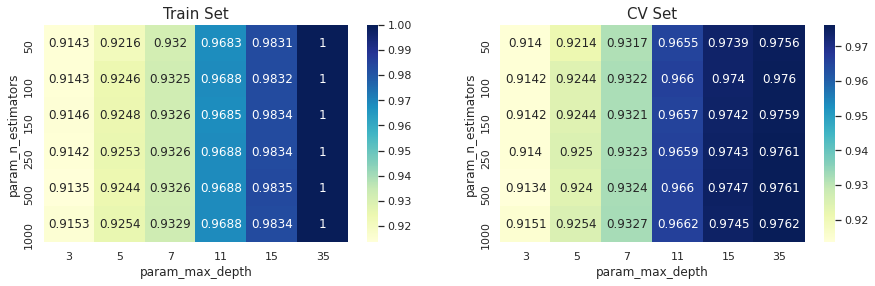

In [ ]:
# plot the performance of model both on train data and cross validation data for each hyper parameter using a Seaborn Heatmap
# reference -> https://kavisekhon.com/Grid%20Search.html

sns.set()
max_scores = pd.DataFrame(clf.cv_results_).groupby(
            ['param_n_estimators', 'param_max_depth']).max().unstack()[
            ['mean_train_score', 'mean_test_score']]

fig, ax = plt.subplots(1,2, figsize=(15,4))
sns.heatmap(max_scores.mean_train_score, annot = True, ax = ax[0], fmt = '.4g', cmap = "YlGnBu")
sns.heatmap(max_scores.mean_test_score, annot = True, ax = ax[1], fmt ='.4g', cmap = "YlGnBu")

ax[0].set_title('Train Set', fontsize = 15)
ax[1].set_title('CV Set', fontsize = 15)
plt.show()

n_estimators = 150

max_depth = 15

In [ ]:
# random forest classifier with optimal hyperparameters found above 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

rfc = RandomForestClassifier(n_estimators = 150, max_depth = 15, random_state = 101, n_jobs = -1)
rfc.fit(X_train, y_train)
y_pred_train =  rfc.predict(X_train)
y_pred_test = rfc.predict(X_test)
train_f1 = f1_score(y_train, y_pred_train)
test_f1 = f1_score(y_test, y_pred_test)
print("Train f1 score = ", train_f1)
print("Test f1 score = ", test_f1)

Train f1 score =  0.9828353079131456
Test f1 score =  0.9343090322444589


In [ ]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    ''' function to construct Confusion matrix, Precision matrix and Recall matrix'''
    C = confusion_matrix(test_y, predict_y) # confusion mtrix
    
    A = (((C.T)/(C.sum(axis=1))).T) # precision matrix
    
    B = (C/C.sum(axis=0)) # recall matrix
    
    plt.figure(figsize=(20, 4))
    labels = [0, 1]
    # representing Confusion matrix in heatmap format
    #cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot = True,  fmt=".3f", xticklabels = labels, yticklabels = labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    # representing Precision matrix in heatmap format
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot = True,  fmt=".3f", xticklabels = labels, yticklabels = labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing Recall matrix in heatmap format
    sns.heatmap(A, annot = True,  fmt=".3f", xticklabels = labels, yticklabels = labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Train confusion_matrix - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


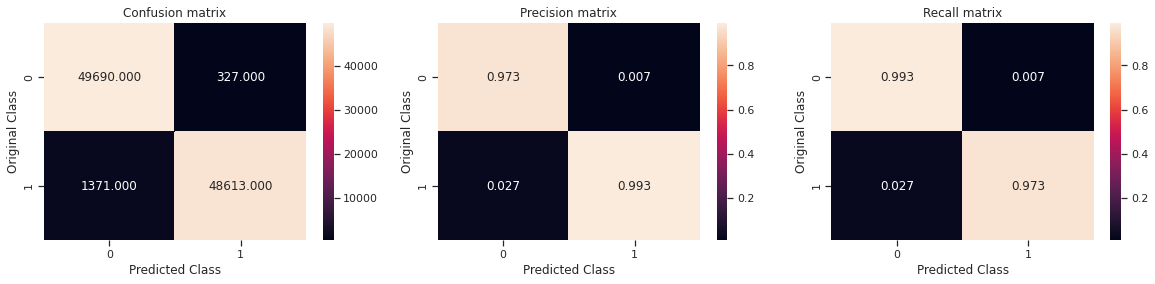


Train F1 score: 0.9828
Train Accuracy: 98.3 %
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Test confusion_matrix - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


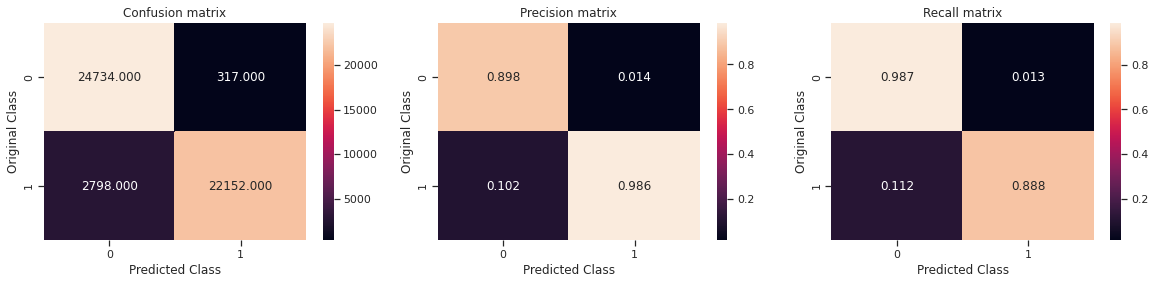


Test F1 score: 0.9343
Test Accuracy: 93.77 %


In [ ]:
# plotting confusion matrix, precision matrix and recall matrix

train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print("- "*30, 'Train confusion_matrix', "- "*30)
plot_confusion_matrix(y_train, y_pred_train)
print("\nTrain F1 score:", round(train_f1, 4))
print("Train Accuracy:", round(train_accuracy*100, 2), "%")


print("- "*30, 'Test confusion_matrix', "- "*30)
plot_confusion_matrix(y_test, y_pred_test)
print("\nTest F1 score:", round(test_f1, 4))
print("Test Accuracy:", round(test_accuracy*100, 2), "%")

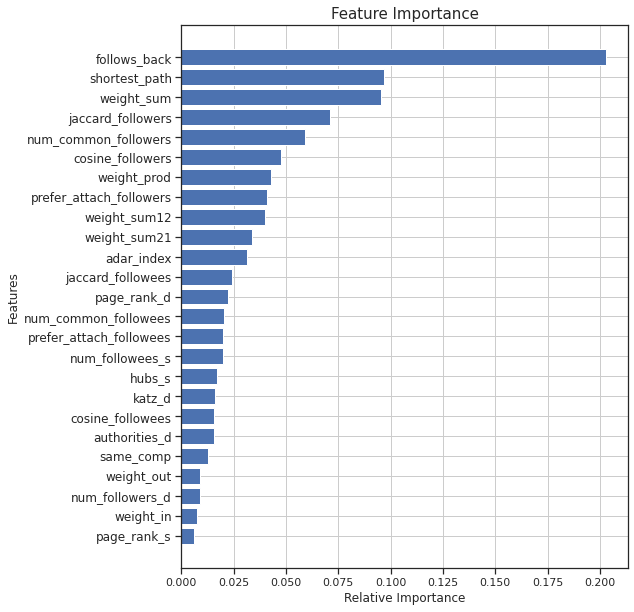

In [ ]:
# relative feature importance 

features = X_train.columns
importance = rfc.feature_importances_
indices = (np.argsort(importance))[-25:] # top 25 features
sns.set(style = 'ticks')
plt.figure(figsize=(8, 10))
plt.title('Feature Importance', fontsize = 15)
plt.barh(range(len(indices)), importance[indices], align ='center')
plt.yticks(range(len(indices)), [features[i] for i in indices], fontsize = 12)
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.grid()
plt.show()

## 6.2 XGBoost

In [ ]:
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

xgb = XGBClassifier(n_jobs = -1, random_state = 21)
params = {'n_estimators': [150, 250, 500, 750], 
          'max_depth': [3, 5, 7, 15, 35]}
clf = GridSearchCV(xgb, params, scoring = 'f1', cv = 5, return_train_score = True, n_jobs = -1)
clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=-1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=21, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 15, 35],
                         'n_estimators': [150, 250, 500, 750]},
             pre_dispatch='2*n_jobs', refit=True, return

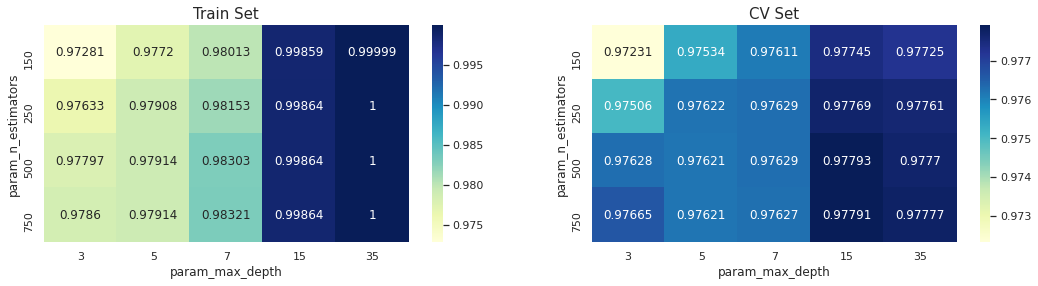

In [ ]:
# plot the performance of model both on train data and cross validation data for each hyper parameter using a Seaborn Heatmap
# reference -> https://kavisekhon.com/Grid%20Search.html

sns.set()
max_scores = pd.DataFrame(clf.cv_results_).groupby(
            ['param_n_estimators', 'param_max_depth']).max().unstack()[
            ['mean_train_score', 'mean_test_score']]

fig, ax = plt.subplots(1,2, figsize = (18, 4))
sns.heatmap(max_scores.mean_train_score, annot = True, ax = ax[0], fmt = '.5g', cmap = "YlGnBu")
sns.heatmap(max_scores.mean_test_score, annot = True, ax = ax[1], fmt ='.5g', cmap = "YlGnBu")

ax[0].set_title('Train Set', fontsize = 15)
ax[1].set_title('CV Set', fontsize = 15)
plt.show()

n_estimator = 500

max_depth = 15

In [ ]:
# train xgboost model with the optimal hyperparameters found above 

xgb = XGBClassifier(n_estimators = 500, max_depth = 15, n_jobs = -1, random_state = 21)
xgb.fit(X_train, y_train)
y_pred_train =  xgb.predict(X_train)
y_pred_test = xgb.predict(X_test)
train_f1 = f1_score(y_train, y_pred_train)
test_f1 = f1_score(y_test, y_pred_test)

print("Train f1 score = ", train_f1)
print("Test f1 score = ", test_f1)

Train f1 score =  0.9941953884470154
Test f1 score =  0.931827775432672


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Train confusion_matrix - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


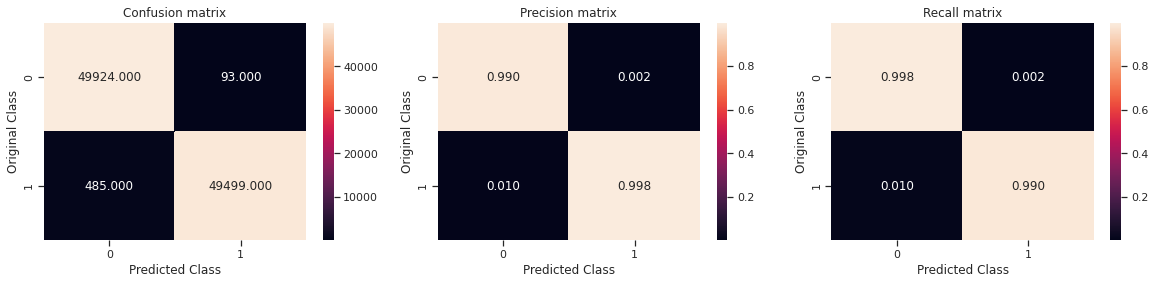


Train F1 score: 0.9942
Train Accuracy: 99.42 %
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Test confusion_matrix - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


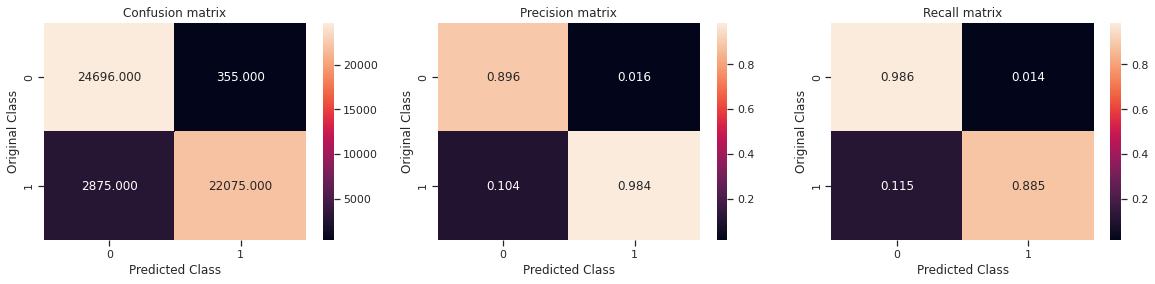


Test F1 score: 0.9318
Test Accuracy: 93.54 %


In [ ]:
# plotting confusion matrix, precision matrix and recall matrix

train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print("- "*30, 'Train confusion_matrix', "- "*30)
plot_confusion_matrix(y_train, y_pred_train)
print("\nTrain F1 score:", round(train_f1, 4))
print("Train Accuracy:", round(train_accuracy*100, 2), "%")

print("- "*30, 'Test confusion_matrix', "- "*30)
plot_confusion_matrix(y_test, y_pred_test)
print("\nTest F1 score:", round(test_f1, 4))
print("Test Accuracy:", round(test_accuracy*100, 2), "%")

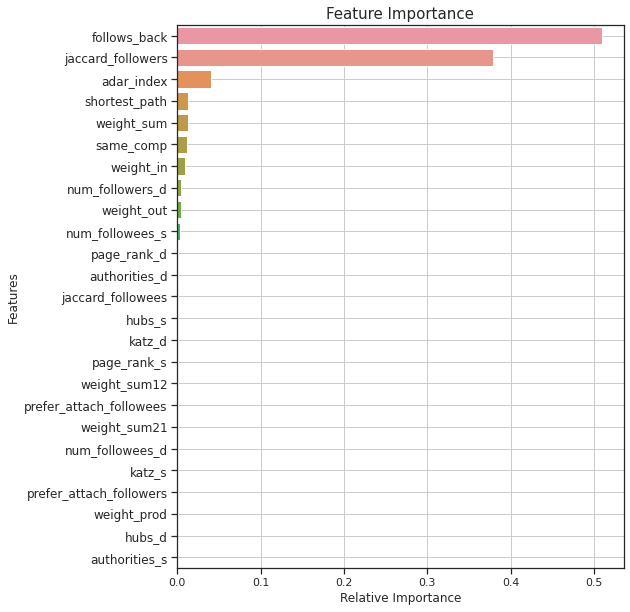

In [ ]:
# relative feature importance

feat_df = pd.DataFrame({'Features' : X_train.columns, 'Relative Importance' :xgb.feature_importances_})
imp_feat_df = feat_df.sort_values('Relative Importance', ascending = False)[:25]
sns.set(style = 'ticks')
plt.figure(figsize = (8, 10))
sns.barplot(y = 'Features', x = 'Relative Importance', data = imp_feat_df)
plt.title('Feature Importance', fontsize = 15)
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.yticks(fontsize = 12)
plt.grid()
plt.show()

# 7. Summary and Conclusion

In [ ]:
from prettytable import PrettyTable
table = PrettyTable()
table.field_names = ('Sr.no.','Model', 'F1 Score', 'Accuracy(in %)')
table.add_row(["1.\n", "Random Forest", 0.9343, 93.77])
table.add_row(["2.", "XGBoost", 0.9318, 93.54])
print(table)

+--------+---------------+----------+----------------+
| Sr.no. |     Model     | F1 Score | Accuracy(in %) |
+--------+---------------+----------+----------------+
|   1.   | Random Forest |  0.9343  |     93.77      |
|        |               |          |                |
|   2.   |    XGBoost    |  0.9318  |     93.54      |
+--------+---------------+----------+----------------+


### SUMMARY 

1. Given a directed Social graph, the task is to predict the missing links in order to recommend users. The dataset consisted of 2 columns -

  column1: source_node (int64)

  column2: destinantion_node(int64)
  

2. Social-media in itself is a giant network in which the connections can be visualized as a graph. We've used NetworkX Python API to create a graph framework from the given source and destination (nodes) data. 


3. Exploratory Data Analysis revealed that - 
  * the dataset consists of nearly 1.86 million distinct Users making a total of 9.43 Million connections with other Users. 
  * On an average each User followed 5 different Users, and on an average each User got followed back by 5 another Users.
  * Majority of the Users had very less followers (99% of Users had 40 or less followers). At least half of the Users had less than 2 followers. 
  * Likewise, Followee stats wasn't much different either. More than half of the Users followed just 1 or 2 other Users, and almost 90% of the Users followed at most 6 other Users.
  

4. Formulating a machine learning task: Our dataset consist of the pair of nodes that are already linked. This can be assigned class label = 1, as there is already a link present between them. In order to convert the given task into a Machine Learning classification problem, we randomly introduced equal number of 'missing links' or 'false links' into the dataset. That is, we randomly generated a pair of nodes from the existing set of all nodes, such that they are not already linked. To these pair of nodes, we assigned class label = 0.


5. Next we combine these postive and negative class label datapoints and split them into train and test in ratio of 80:20 for training and testing respectively. 


6. Before going to build machine learning model, we performed extensive feature engineering and added over 28 new features. This includes: 
  * Set specific features - Jaccard Index, Adar index, Otsuka-Ochiai similarity coefficient, preferential attachment etc. This we implement for both followees and followers. 
  * Graph specific features - Page Rank index, Shortest path length, Katz Centrality, Hubs and Authorities score, etc. These are implemented seperately for source and destination node(as and when applicable).
  * Some other features like - If source and destination node belong to the same community(weakly connected components), is User following back, Weight of the nodes based on followers and followees stats etc. 
  
    Note that most of these above feature we constructed required the knowledge of predecessors and successors of each node in the graph; and this information can be easily obtained by using NetworkX API for Python. 


7. One important thing we noticed in this is that some of the features like HITS Score, Page Rank etc. had exteremly low magnitude (i.e. of order ~ 10^-15 to 10^-20). So these features might slow down computation or may even get ignored internally in tree-based algos. So, in order to make these features meaningful, we decided to take their negative inverse logarithm i.e. - 1/log10(feat) instead of using them directly. 


8. If we decide to include all 18 millions datapoints for building our machine learning model, it would be computationally very expensive. Considering the limited RAM & GPU, we randomly selected 100k datapoints as our Train data from over 15 million Train records, and for test dataset, we randomly selected 50k datapoints from over 3 million Test records in order to build a machine learning model. 


9. As the data we are working on is static, latency requirement isn't a concern as of now. The predictions can be precomputed and stored in a hastable like DS and passed into the UI upon User's login.  


10. For this project, we trained 2 tree-based ensemble models - Random Forest and XGBoost. The performance metric selected was F1 Score. For every model, Accuracy, Confusion matrix, Precision matrix, and Recall was also reported.


11. It was observed that both the models gave nearly similar performances. The feature importance analysis reveals that 'follows_back', which is a binary feature representing whether there is a directed link from destination to source node is the most important feature in our prediction task. Other important features include Jaccard index, Similarity coefficient, Shortest path length, Preferential attachment and Weight features based on followers and followees. 


12. Although our analysis and the subequent modelling was based on the static dataset, in real world, the follower-followee graph is very dynamic in nature. Everyday people follow and unfollow many other Users. This Project helped me set the right foundation to dive into the real-word problem of handling dynamic datasets in future.